In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
import os
from palettable.cartocolors.qualitative import Prism_9



In [2]:
answer_type_names = ["types5_seed2_temp0.8", "types50_seed2_temp0.8", "types5_seed2", "types50_seed2", "types10_seed2_temp0.8"]


def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))

    for ckpt in ckpts:
        
        for answer_type_name in answer_type_names:
            try:
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_"+answer_type_name+".npy")==0)
                break
            except:
                pass
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    if "full" not in train_name:
        subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
    else:
        subsample_idxs = np.arange(len(train_accs_all[0]))
    
    train_accs_all = np.array(train_accs_all)[:, subsample_idxs]
    perplexities_all = np.array(perplexities_all)[:, subsample_idxs]
    
    
    
    test_accs_all = []

    for ckpt in ckpts:
        for answer_type_name in answer_type_names:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_"+answer_type_name+".npy")==0)
                break
            except:
                pass
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict


def get_ratios(stats_dict, perp_threshold=-2.5):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):
        accs_all[i] =train_accs_all[i]
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    
    return_dict = {} 
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax
    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


In [3]:
stats_dict5 = get_stats("gsm8k_orig_6epochs_full_lr5e-05_bs128")
stats_dict7 = get_stats("gsm8k_orig_6epochs_full_lr5e-07_bs128")
stats_dict52 = get_stats("gsm8k_orig_6epochs_full_lr2e-05_bs128")
stats_dict4 = get_stats("gsm8k_orig_6epochs_full_lr0.0002_bs128")

stats_dict5_3 = get_stats("gsm8k_orig_3epochs_full_lr5e-05_bs128")
stats_dict52_3 = get_stats("gsm8k_orig_3epochs_full_lr2e-05_bs128")
stats_dict7_3 = get_stats("gsm8k_orig_3epochs_full_lr5e-07_bs128")
stats_dict4_3 = get_stats("gsm8k_orig_3epochs_full_lr0.0002_bs128")

stats_dict5_1 = get_stats("gsm8k_orig_1epochs_full_lr5e-05_bs128")
stats_dict7_1 = get_stats("gsm8k_orig_1epochs_full_lr5e-07_bs128")
stats_dict4_1 = get_stats("gsm8k_orig_1epochs_full_lr0.0002_bs128")

stats_dict_half = get_stats("gsm8k_orig_6epochs_half_lr2e-05_bs128")
stats_dict_quarter = get_stats("gsm8k_orig_12epochs_quarter_lr2e-05_bs128")

In [4]:
perp_threshold=-2.3

ratios_dict5 =  get_ratios(stats_dict5, perp_threshold=perp_threshold)
ratios_dict52 =  get_ratios(stats_dict52, perp_threshold=perp_threshold)
ratios_dict7 =  get_ratios(stats_dict7, perp_threshold=perp_threshold)
ratios_dict4 =  get_ratios(stats_dict4, perp_threshold=perp_threshold)

ratios_dict5_3 =  get_ratios(stats_dict5_3, perp_threshold=perp_threshold)
ratios_dict52_3 =  get_ratios(stats_dict52_3, perp_threshold=perp_threshold)
ratios_dict7_3 =  get_ratios(stats_dict7_3, perp_threshold=perp_threshold)
ratios_dict4_3 =  get_ratios(stats_dict4_3, perp_threshold=perp_threshold)

ratios_dict5_1 =  get_ratios(stats_dict5_1, perp_threshold=perp_threshold)
ratios_dict7_1 =  get_ratios(stats_dict7_1, perp_threshold=perp_threshold)
ratios_dict4_1 =  get_ratios(stats_dict4_1, perp_threshold=perp_threshold)

ratios_dict_half =  get_ratios(stats_dict_half, perp_threshold=perp_threshold)
ratios_dict_quarter =  get_ratios(stats_dict_quarter, perp_threshold=perp_threshold)


In [5]:
color_dict = {}

color_dict["2e-4"] = Prism_9.mpl_colors[2]
color_dict["5e-4"] = Prism_9.mpl_colors[3]
color_dict["2e-5"] = Prism_9.mpl_colors[4]
color_dict["5e-5"] = Prism_9.mpl_colors[5]
color_dict["5e-6"] = Prism_9.mpl_colors[6]
color_dict["5e-7"] = Prism_9.mpl_colors[7]

/tmp/ipykernel_374346/2698064729.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "v-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(ratios_dict_half["unmemorized_acc_cummax"][[1,3,5]], ratios_dict_half["avg_test_acc"][[1,3,5]], "v-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
/tmp/ipykernel_374346/2698064729.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "v-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(ratios_dict_quarter["unmemorized_acc_cummax"][[1,3,5]], ratios_dict_quarter["avg_test_acc"][[1,3,5]], "v-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)


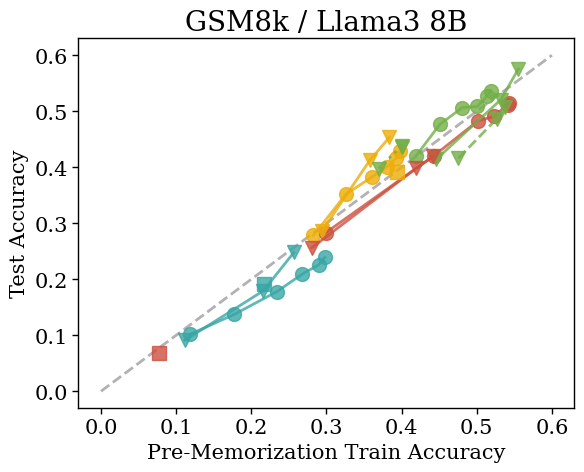

In [6]:

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
})

plt.plot([0, 0.6], [0, 0.6], "--", color="black", alpha=0.3, linewidth=2)


plt.plot(ratios_dict5["unmemorized_acc_cummax"], ratios_dict5["avg_test_acc"], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 6", linewidth=2)
plt.plot(ratios_dict52["unmemorized_acc_cummax"], ratios_dict52["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="lr 2e-5 epochs 6", linewidth=2)
plt.plot(ratios_dict7["unmemorized_acc_cummax"], ratios_dict7["avg_test_acc"], "o-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 6", linewidth=2)
plt.plot(ratios_dict4["unmemorized_acc_cummax"], ratios_dict4["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4 epochs 6", linewidth=2)


plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "v-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 3", linewidth=2)
plt.plot(ratios_dict52_3["unmemorized_acc_cummax"], ratios_dict52_3["avg_test_acc"], "v-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="lr 2e-5 epochs 3", linewidth=2)
plt.plot(ratios_dict7_3["unmemorized_acc_cummax"], ratios_dict7_3["avg_test_acc"], "v-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 3", linewidth=2)
plt.plot(ratios_dict4_3["unmemorized_acc_cummax"], ratios_dict4_3["avg_test_acc"], "v-", markersize=10, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4 epochs 3", linewidth=2)

plt.plot(ratios_dict5_1["unmemorized_acc_cummax"], ratios_dict5_1["avg_test_acc"], "s-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 1", linewidth=2)
plt.plot(ratios_dict7_1["unmemorized_acc_cummax"], ratios_dict7_1["avg_test_acc"], "s-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 1", linewidth=2)
plt.plot(ratios_dict4_1["unmemorized_acc_cummax"], ratios_dict4_1["avg_test_acc"], "s-", markersize=10, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4 epochs 1", linewidth=2)


plt.plot(ratios_dict_half["unmemorized_acc_cummax"][[1,3,5]], ratios_dict_half["avg_test_acc"][[1,3,5]], "v-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
plt.plot(ratios_dict_quarter["unmemorized_acc_cummax"][[1,3,5]], ratios_dict_quarter["avg_test_acc"][[1,3,5]], "v-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)



plt.xlabel("Pre-Memorization Train Accuracy", fontsize=15)
plt.ylabel("Test Accuracy", fontsize=15)
plt.title("GSM8k / Llama3 8B", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.tick_params(width=1, length=4)